In [1]:
import getpass
import sys
import time
import pandas as pd
from scipy import stats
import numpy as np
import seaborn as sns
from scipy.stats import linregress
import warnings
from tqdm import tqdm
from matplotlib import pyplot as plt
warnings.filterwarnings('ignore')

# Get transcriptomic and target vectors

In [2]:
transcriptomic_responses_df = pd.read_csv(
    '../data/Transcriptional_data_frames/transcriptional_response_vectors_cell_line.tsv',
    sep='\t',
    index_col=0,
)

In [3]:
#Remove transcriptomic responses with less than 100 DEGs
for index in tqdm(transcriptomic_responses_df.index.values):
    if sum(abs(transcriptomic_responses_df.loc[index])) < 100:
        transcriptomic_responses_df = transcriptomic_responses_df.drop(index, axis=0)

100%|███████████████████████████████████████| 8781/8781 [01:35<00:00, 92.37it/s]


In [4]:
import os
os.getcwd()

'/Users/chloeengler/Documents/Transcriptomic/drug-transcriptomics-target-correlation/notebooks'

In [5]:
#Get ChemPert target vectors
targets_df = pd.read_csv(
    '../data/target_data_frames/target_vectors_ChemPert.tsv',
    sep='\t',
    index_col=0,
)

#Get ChemPert(KEGG) target vectors
kegg_targets_df = pd.read_csv(
            '../data/target_data_frames/target_vectors_ChemPert(KEGG).csv',
            sep=',',
            index_col=0,
        )

#Get ChemPert(Topological) target vectors
network_targets_df = pd.read_csv(
            '../data/target_data_frames/target_vectors_ChemPert(Topological).csv',
            sep=',',
            index_col=0,
        )

#Get ChemPert(Topological_Level_2) target vectors
network_repeated_targets_df = pd.read_csv(
            '../data/target_data_frames/target_vectors_ChemPert(Topological_Level_2).csv',
            sep=',',
            index_col=0,
        )


# Get Cell Lines

In [6]:
response_metdata_df = pd.read_csv(
    's3://enveda-data-raw/chempert/Information_for_transcriptional_responses.csv',
    usecols=[
        'Response_ID',
        'Chemical_ID',
        'Concentration',
        'Cell_Source'
    ],
    index_col='Response_ID',
)
response_metdata_df.head(4)


,Chemical_ID,Cell_Source,Concentration
Response_ID,,,
RID00001,CID01777,Hepatocyte,10uM
RID00002,CID01777,Hepatocyte,50uM
RID00003,CID01776,Hepatocyte,75uM
RID00004,CID51798,Hepatocyte,300uM


In [7]:
#Create dictionary of cell lines for each drug
cell_lines = {}
for drug in tqdm(targets_df.index.values):
    current_cell_lines = [x.split('_')[1] for x in transcriptomic_responses_df.index.values if x.startswith(drug)]
    cell_lines[drug] = np.unique(current_cell_lines)
    

100%|██████████████████████████████████████| 2152/2152 [00:02<00:00, 863.78it/s]


# Calculate correlation between all target vectors

In [8]:
from scipy.spatial.distance import jaccard
from tqdm import tqdm_notebook
from itertools import permutations, combinations
import time

In [9]:
def get_jaccard_correlation(
    target_matrix: pd.DataFrame
):
    """Get Jaccard similarity for each drug."""
    n = len(target_matrix.index.values)
    correlation_df = pd.DataFrame(columns = targets_df.index.values, index=targets_df.index.values)
    all_combinations = combinations(targets_df.index.values, 2)
    all_pairs = []
    for pair in all_combinations:
        all_pairs.append(pair) 
    
    for k,pair in enumerate(tqdm(all_pairs)):
        drug_1 = pair[0]
        drug_2 = pair[1]
        target_vector_1 = target_matrix.loc[drug_1, :]
        target_vector_2 = target_matrix.loc[drug_2, :]
        dissimilarity_score = jaccard(target_vector_1, target_vector_2)
        similarity = 1 - dissimilarity_score
        correlation_df.loc[drug_1, drug_2] = similarity
    return correlation_df

In [10]:
similarity_df = get_jaccard_correlation(targets_df)
kegg_similarity_df = get_jaccard_correlation(kegg_targets_df)
network_similarity_df = get_jaccard_correlation(network_targets_df)
network_repeated_similarity_df = get_jaccard_correlation(network_repeated_targets_df)


100%|███████████████████████████████| 2314476/2314476 [08:58<00:00, 4296.24it/s]


# Calculate correlation between all transcriptomic vectors

In [11]:
def get_jaccard_correlation_transcripts(
    target_matrix: pd.DataFrame
):
    """Get Jaccard similarity for each drug."""
    n = len(target_matrix.index.values)
    correlation_df = pd.DataFrame(columns = transcriptomic_responses_df.index.values, \
                                  index=transcriptomic_responses_df.index.values)
    all_combinations = combinations(transcriptomic_responses_df.index.values, 2)
    all_pairs = []
    for pair in all_combinations:
        all_pairs.append(pair) 
    
    for k,pair in enumerate(tqdm(all_pairs)):
        drug_1 = pair[0]
        drug_2 = pair[1]
        if drug_1.split('_')[1] == drug_2.split('_')[1]:
            target_vector_1 = target_matrix.loc[drug_1, :]
            target_vector_2 = target_matrix.loc[drug_2, :]
            dissimilarity_score = jaccard(target_vector_1, target_vector_2)
            similarity = 1 - dissimilarity_score
            correlation_df.loc[drug_1, drug_2] = similarity
    return correlation_df


In [12]:
transcript_similarity_df = get_jaccard_correlation_transcripts(transcriptomic_responses_df)


100%|████████████████████████████| 34150980/34150980 [19:13<00:00, 29606.28it/s]


# Calculate correlation between target vector similarity and transcriptomic vector similarity

In [13]:
#Create lists
all_pairs = []
similarity_array = []
transcript_similarity_array = []
kegg_similarity_array = []
network_similarity_array = []
network_repeated_similarity_array = []

#Get all pairs of drugs
all_combinations = combinations(transcriptomic_responses_df.index.values, 2)
for pair in all_combinations:
    all_pairs.append(pair) 

#Get array of transcriptomic similarity scores
#and arrays of target similarity scores for each database
for drug_1, drug_2 in tqdm(all_pairs):
    transcript_score = transcript_similarity_df.loc[drug_1, drug_2]
    target_score = similarity_df.loc[drug_1.split('_')[0], drug_2.split('_')[0]]
    kegg_score = kegg_similarity_df.loc[drug_1.split('_')[0], drug_2.split('_')[0]]
    network_score = network_similarity_df.loc[drug_1.split('_')[0], drug_2.split('_')[0]]
    network_repeated_score = network_repeated_similarity_df.loc[drug_1.split('_')[0], drug_2.split('_')[0]]
    if not pd.isna(transcript_score) and not pd.isna(target_score):
        transcript_similarity_array.append(transcript_score)
        similarity_array.append(target_score)
        kegg_similarity_array.append(kegg_score)
        network_similarity_array.append(network_score)
        network_repeated_similarity_array.append(network_repeated_score)
        



100%|████████████████████████████| 34150980/34150980 [21:25<00:00, 26567.92it/s]


In [14]:
from scipy.stats import pearsonr
print("Pearson correlation for ChemPert vectors: " \
      + str(pearsonr(similarity_array, transcript_similarity_array)[0]))
print("Pearson correlation for ChemPert(KEGG) vectors: "\
      + str(pearsonr(kegg_similarity_array, transcript_similarity_array)[0]))
print("Pearson correlation for ChemPert(Topological) vectors: "\
      + str(pearsonr(network_similarity_array, transcript_similarity_array)[0]))
print("Pearson correlation for ChemPert(Topological_Level_2) vectors: "\
      + str(pearsonr(network_repeated_similarity_array, transcript_similarity_array)[0]))

Pearson correlation for ChemPert vectors: 0.012148896414815421
Pearson correlation for ChemPert(KEGG) vectors: 0.05176033037103553
Pearson correlation for ChemPert(Topological) vectors: 0.015258048652392105
Pearson correlation for ChemPert(Topological_Level_2) vectors: 0.016084772409025692


# Look at pairs where the target vectors are highly correlated

In [15]:
target_vals = []
transcript_vals = []

#Get drug pairs that have all the same targets
high_corr_targets = similarity_df.reset_index().melt(id_vars='index').query('value == 1.0')

#Get transcriptomic simialrity scores for drug pairs that share all their targets
for pair in tqdm_notebook(high_corr_targets.index.values):
    drug_1 = high_corr_targets.loc[pair, 'index']
    drug_2 = high_corr_targets.loc[pair, 'variable']
    for line in cell_lines[drug_1]:
        for line_2 in cell_lines[drug_2]:
            if line == line_2:
                target_vals.append(1)
                transcript_vals.append( transcript_similarity_df.loc[drug_1 + '_' + line, \
                                                                    drug_2 + '_' + line])

  0%|          | 0/1167 [00:00<?, ?it/s]

<Figure size 360x1440 with 0 Axes>

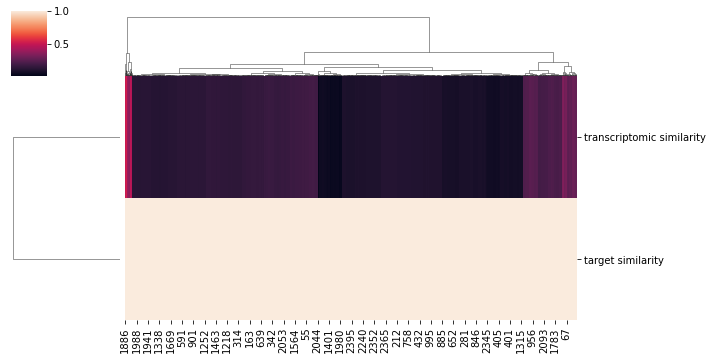

In [16]:
import seaborn as sns
import numpy as np

#Create data frame with target similarity scores and transcriptomic similarity scores
high_corr_target_df = np.array([transcript_vals, np.ones(len(transcript_vals))])
high_corr_target_df = pd.DataFrame(high_corr_target_df, index = ['transcriptomic similarity', \
                                                                 'target similarity'])
#Show clustermap of similarity scores
plt.figure(figsize=([5,20]))
sns.clustermap(high_corr_target_df, figsize=(10,5))
plt.show()


In [17]:
print('Average transcriptomic similarity for drug pairs that share all targets: ' \
     + str(sum(transcript_vals)/len(transcript_vals)))
print('Average transcriptomic similarity all drug pairs: ' \
     + str(sum(transcript_similarity_array)/len(transcript_similarity_array)))

Average transcriptomic similarity for drug pairs that share all targets: 0.1398716884693998
Average transcriptomic similarity all drug pairs: 0.13021816263292407


### Save highly correlated pairs

In [18]:
#Create lists
all_drug_1 = []
all_drug_2 = []
num_nonzero_targets_1 = []
num_nonzero_targets_2 = []
num_nonzero_transcript_1 = []
num_nonzero_transcript_2 = []
num_shared_targets = []
num_shared_DEGs = []
target_vals = []
transcript_vals = []

#Get more information about the drug pairs that share all their targets
for pair in high_corr_targets.index.values:
    drug_1 = high_corr_targets.loc[pair, 'index']
    drug_2 = high_corr_targets.loc[pair, 'variable']
     
    #Get target vector for both drugs
    target_array_1 = np.array(targets_df.loc[drug_1])
    target_array_2 = np.array(targets_df.loc[drug_2])
    
    #Get locations of targets for both drugs
    nonzero_target_1 = np.nonzero(target_array_1)[0]
    nonzero_target_2 = np.nonzero(target_array_2)[0]
    
    #Get list of shared targets for both drugs
    nonzero_targets = list(set(nonzero_target_1) & set (nonzero_target_2))
    shared_targets = [i for i in nonzero_targets if target_array_1[i] == target_array_2[i]]
    
    #Look at the transcriptomic vectors for every cell line 
    for line in cell_lines[drug_1]:
        for line_2 in cell_lines[drug_2]:
            if line == line_2: 
                #Get transcriptomic similarity score
                transcript_vals.append(transcript_similarity_df.loc[drug_1 + '_' + line, \
                                                                    drug_2 + '_' + line])
                
                #Get the DEGs for the first drug
                transcript_array_1 = np.array(transcriptomic_responses_df.loc[drug_1 + '_' + line])
                nonzero_transcript_1 = np.nonzero(transcript_array_1)[0]
                num_nonzero_transcript_1.append(len(nonzero_transcript_1))

                #Get the DEGs for the second drug
                transcript_array_2 = np.array(transcriptomic_responses_df.loc[drug_2 + '_' + line])
                nonzero_transcript_2 = np.nonzero(transcript_array_2)[0]
                num_nonzero_transcript_2.append(len(nonzero_transcript_2))

                #Get the number of shared DEGs
                nonzero_transcripts = list(set(nonzero_transcript_1) & set (nonzero_transcript_2))
                shared_DEGs = [i for i in nonzero_transcripts if transcript_array_1[i] == transcript_array_2[i]]
                num_shared_DEGs.append(len(shared_DEGs))
                
                #Add both drugs to list of all drug names
                all_drug_1.append(drug_1 + '_' + line)
                all_drug_2.append(drug_2 + '_' + line)
                
                #Get number of shared targets
                num_nonzero_targets_1.append(len(nonzero_target_1))
                num_nonzero_targets_2.append(len(nonzero_target_2))
                num_shared_targets.append(len(shared_targets))
                target_vals.append(similarity_df.loc[drug_1, drug_2])
                    

In [19]:
#Load chemical names data frame
chemical_names = pd.read_csv('../data/ChemPert_data/Information_for_perturbagens_2.csv', sep='@')
chemical_names = chemical_names.set_index("'id'")
chemical_names.head()

#Create chemical names dictionary
chemical_names_dict_keys = list(chemical_names['Chemical_ID'])
chemical_names_dict_values = list(chemical_names['Chemical_Compound'])
chemical_names_dict = {chemical_names_dict_keys[i]:chemical_names_dict_values[i] for i in \
                       range(len(chemical_names_dict_values))}

In [20]:
#Create data frame with information about the drug pairs that share targets
high_corr_targets_cell_lines = pd.DataFrame()
high_corr_targets_cell_lines['drug_1'] = all_drug_1
high_corr_targets_cell_lines['drug_2'] = all_drug_2
high_corr_targets_cell_lines['transcriptomic_similarity'] = transcript_vals
high_corr_targets_cell_lines['target_similarity'] = target_vals
high_corr_targets_cell_lines['num_nonzero_targets_1'] = num_nonzero_targets_1
high_corr_targets_cell_lines['num_nonzero_targets_2'] = num_nonzero_targets_2
high_corr_targets_cell_lines['num_nonzero_transcript_1'] = num_nonzero_transcript_1
high_corr_targets_cell_lines['num_nonzero_transcript_2'] = num_nonzero_transcript_2
high_corr_targets_cell_lines['num_shared_targets'] = num_shared_targets
high_corr_targets_cell_lines['num_shared_DEGs'] = num_shared_DEGs
high_corr_targets_cell_lines['drug_name_1'] = [chemical_names_dict[drug.split('_')[0]] for drug in all_drug_1]
high_corr_targets_cell_lines['drug_name_2'] = [chemical_names_dict[drug.split('_')[0]] for drug in all_drug_2]
high_corr_targets_cell_lines = high_corr_targets_cell_lines[['drug_1', 'drug_2', 'drug_name_1', 'drug_name_2', 
                                        'target_similarity','transcriptomic_similarity',
                                        'num_nonzero_targets_1', 'num_nonzero_targets_2',
                                        'num_nonzero_transcript_1', 'num_nonzero_transcript_2',
                                        'num_shared_targets', 'num_shared_DEGs']]

In [21]:
high_corr_targets_cell_lines.to_csv('../data/target_high_correlation_cell_lines.csv')

# Look at pairs where the transcriptomic vectors are highly correlated

In [22]:
target_vals = []

#Get drug pairs where the transcriptomic vectors are highly correlated
high_corr_transcripts = transcript_similarity_df.reset_index().melt(id_vars='index').query('value >= .6')

#Get target similarity values for drug pairs with high transcriptomic similarity
for pair in high_corr_transcripts.index.values:
    drug_1 = high_corr_transcripts.loc[pair, 'index'].split('_')[0]
    drug_2 = high_corr_transcripts.loc[pair, 'variable'].split('_')[0]
    target_vals.append(similarity_df.loc[drug_1, drug_2])
    

<Figure size 3000x2000 with 0 Axes>

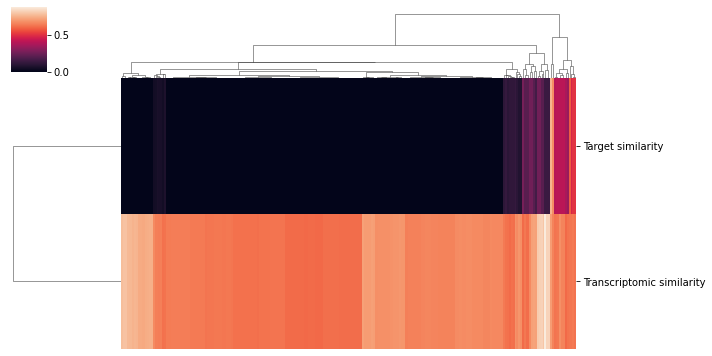

In [23]:
#Create data frame with target similarity values and transcriptomic similarity values
high_corr_target_df = np.array([target_vals, list(high_corr_transcripts['value'])])
high_corr_target_df = pd.DataFrame(high_corr_target_df, index = ['Target similarity', \
                                                                 'Transcriptomic similarity'])

#Create figure of target and transcriptomic similarity values
plt.figure(dpi=500)
sns.clustermap(high_corr_target_df, figsize=(10,5), xticklabels=False,yticklabels=True)
plt.savefig('../figures/figure_4.png', bbox_inches='tight')
plt.show()

In [24]:
all_target_vals = []
all_pairs = []

#Get all pairs of drugs
all_combinations = combinations(transcriptomic_responses_df.index.values, 2)
for pair in all_combinations:
    all_pairs.append(pair) 

for pair in tqdm(all_pairs):
    drug_1 = pair[0]
    drug_2 = pair[1]
    if not pd.isna(transcript_similarity_df.loc[drug_1, drug_2]):
        all_target_vals.append(similarity_df.loc[drug_1.split('_')[0], drug_2.split('_')[0]])

100%|███████████████████████████| 34150980/34150980 [05:21<00:00, 106349.87it/s]


In [25]:
print('Average target similarity for drug pairs with similar transcripts: ' \
     + str(sum(target_vals)/len(target_vals)))
print('Average target similarity all drug pairs: ' \
     + str(sum(similarity_array)/len(similarity_array)))
print('Percentage of drug pairs with high transcriptomic similarity that share at least one target: '\
     + str(len(np.nonzero(target_vals)[0])/len(target_vals)))
print('Percentage of all drug pairs that share at least one target: '\
     + str(len(np.nonzero(all_target_vals)[0])/len(all_target_vals)))

Average target similarity for drug pairs with similar transcripts: 0.04498597576563522
Average target similarity all drug pairs: 0.0045492129629340905
Percentage of drug pairs with high transcriptomic similarity that share at least one target: 0.1885245901639344
Percentage of all drug pairs that share at least one target: 0.02884004128012519


### Save highly correlated pairs

In [26]:
#Create lists
all_drug_1 = []
all_drug_2 = []
num_nonzero_targets_1 = []
num_nonzero_targets_2 = []
num_nonzero_transcript_1 = []
num_nonzero_transcript_2 = []
num_shared_targets = []
num_shared_DEGs = []
target_vals = []
transcriptomic_vals = []

#Get more information about the drug pairs with high transcriptomic similarity
for pair in high_corr_transcripts.index.values:
    drug_1 = high_corr_transcripts.loc[pair, 'index']
    drug_2 = high_corr_transcripts.loc[pair, 'variable']
    all_drug_1.append(drug_1)
    all_drug_2.append(drug_2)
    transcriptomic_vals.append(high_corr_transcripts.loc[pair, 'value'])
    
    #Get target similarity scores
    target_vals.append(similarity_df.loc[drug_1.split('_')[0], drug_2.split('_')[0]])
    
    #Get target vectors and transcriptomic vectors for both drugs
    target_array_1 = np.array(targets_df.loc[drug_1.split('_')[0]])
    target_array_2 = np.array(targets_df.loc[drug_2.split('_')[0]])
    transcript_array_1 = np.array(transcriptomic_responses_df.loc[drug_1])
    transcript_array_2 = np.array(transcriptomic_responses_df.loc[drug_2])
    
    #Get targets and DEGs for both drugs
    nonzero_target_1 = np.nonzero(target_array_1)[0]
    nonzero_target_2 = np.nonzero(target_array_2)[0]
    nonzero_transcript_1 = np.nonzero(transcript_array_1)[0]
    nonzero_transcript_2 = np.nonzero(transcript_array_2)[0]
    
    #Get number of targets and DEGs for both drugs
    num_nonzero_targets_1.append(len(nonzero_target_1))
    num_nonzero_targets_2.append(len(nonzero_target_2))
    num_nonzero_transcript_1.append(len(nonzero_transcript_1))
    num_nonzero_transcript_2.append(len(nonzero_transcript_2))
    
    #Get shared targets and DEGs
    nonzero_targets = list(set(nonzero_target_1) & set (nonzero_target_2))
    nonzero_transcripts = list(set(nonzero_transcript_1) & set (nonzero_transcript_2))
    shared_targets = [i for i in nonzero_targets if target_array_1[i] == target_array_2[i]]
    shared_DEGs = [i for i in nonzero_transcripts if transcript_array_1[i] == transcript_array_2[i]]
    
    #Get number of shared targets and DEGs
    num_shared_targets.append(len(shared_targets))
    num_shared_DEGs.append(len(shared_DEGs))

In [27]:
#Create data frame with information about the drug pairs
#with high transcriptomic similarity
high_corr_transcripts_cell_lines = pd.DataFrame()
high_corr_transcripts_cell_lines['drug_1'] = all_drug_1
high_corr_transcripts_cell_lines['drug_2'] = all_drug_2
high_corr_transcripts_cell_lines['transcriptomic_similarity'] = transcriptomic_vals
high_corr_transcripts_cell_lines['target_similarity'] = target_vals
high_corr_transcripts_cell_lines['num_nonzero_targets_1'] = num_nonzero_targets_1
high_corr_transcripts_cell_lines['num_nonzero_targets_2'] = num_nonzero_targets_2
high_corr_transcripts_cell_lines['num_nonzero_transcript_1'] = num_nonzero_transcript_1
high_corr_transcripts_cell_lines['num_nonzero_transcript_2'] = num_nonzero_transcript_2
high_corr_transcripts_cell_lines['num_shared_targets'] = num_shared_targets
high_corr_transcripts_cell_lines['num_shared_DEGs'] = num_shared_DEGs
high_corr_transcripts_cell_lines['drug_name_1'] = [chemical_names_dict[drug.split('_')[0]] for drug \
                                                   in high_corr_transcripts_cell_lines['drug_1']]
high_corr_transcripts_cell_lines['drug_name_2'] = [chemical_names_dict[drug.split('_')[0]] for drug \
                                                   in high_corr_transcripts_cell_lines['drug_2']]

high_corr_transcripts_cell_lines = high_corr_transcripts_cell_lines[['drug_1', 'drug_2', 'drug_name_1',\
                                                                     'drug_name_2', 'transcriptomic_similarity', \
                                                                     'target_similarity','num_nonzero_targets_1',\
                                                                     'num_nonzero_targets_2',
                                                                     'num_nonzero_transcript_1', 
                                                                     'num_nonzero_transcript_2',
                                                                     'num_shared_targets', 'num_shared_DEGs']]

In [28]:
high_corr_transcripts_cell_lines.to_csv('../data/transcriptomic_high_correlation_cell_lines.csv')

# Permutation Tests

In [29]:
#Set initial variables
num_permutations = 1000
original_pearson_scores = []
kegg_pearson_scores = []
network_pearson_scores = []
network_repeated_pearson_scores = []

#Do permutation test
for i in tqdm(range(num_permutations)):
    current_transcript_similarity_array = np.array(transcript_similarity_array.copy())
    np.random.shuffle(current_transcript_similarity_array)
    original_pearson_scores.append(pearsonr(similarity_array, current_transcript_similarity_array)[0])
    kegg_pearson_scores.append(pearsonr(kegg_similarity_array, current_transcript_similarity_array)[0])
    network_pearson_scores.append(pearsonr(network_similarity_array, current_transcript_similarity_array)[0])
    network_repeated_pearson_scores.append(pearsonr(network_repeated_similarity_array, 
                                                    current_transcript_similarity_array)[0])
    


100%|███████████████████████████████████████| 1000/1000 [27:18<00:00,  1.64s/it]


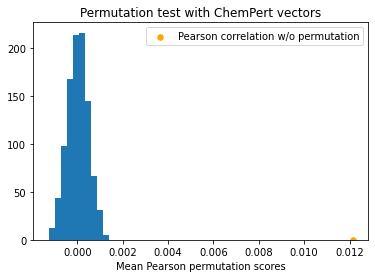

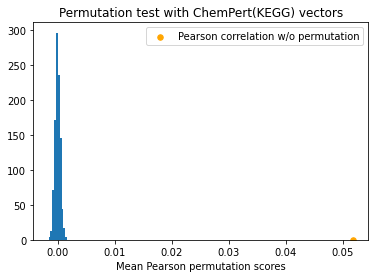

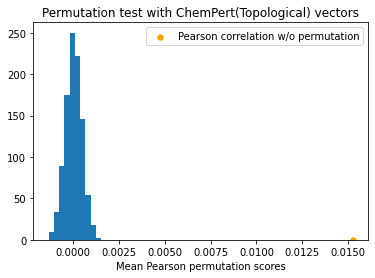

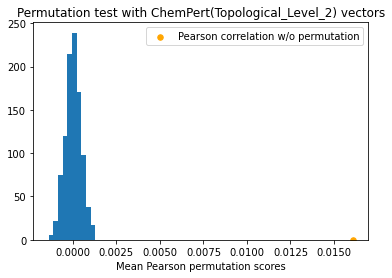

In [31]:
#Permutation test for ChemPert
plt.hist(original_pearson_scores)
plt.scatter(pearsonr(similarity_array, transcript_similarity_array)[0], .3, s=30, color='orange',\
           label='Pearson correlation w/o permutation')
plt.title('Permutation test with ChemPert vectors')
plt.xlabel('Mean Pearson permutation scores')
plt.legend()
plt.show()

#Permutation test for ChemPert with KEGG
plt.hist(kegg_pearson_scores)
plt.scatter(pearsonr(kegg_similarity_array, transcript_similarity_array)[0], .3, s=30, color='orange', \
           label='Pearson correlation w/o permutation')
plt.title('Permutation test with ChemPert(KEGG) vectors')
plt.xlabel('Mean Pearson permutation scores')
plt.legend()
plt.show()

#Permutation test for ChemPert with topological information
plt.hist(network_pearson_scores)
plt.scatter(pearsonr(network_similarity_array, transcript_similarity_array)[0], .3, s=30, color='orange', \
           label='Pearson correlation w/o permutation')
plt.title('Permutation test with ChemPert(Topological) vectors')
plt.xlabel('Mean Pearson permutation scores')
plt.legend()
plt.show()

#Permutation test for ChemPert with topological information at level 2
plt.hist(network_repeated_pearson_scores)
plt.scatter(pearsonr(network_repeated_similarity_array, transcript_similarity_array)[0], .3, s=30, color='orange',\
           label='Pearson correlation w/o permutation')
plt.title('Permutation test with ChemPert(Topological_Level_2) vectors')
plt.xlabel('Mean Pearson permutation scores')
plt.legend()
plt.show()